# TP - Implémentation d'un CNN (Convolutional Neural Network)

## Objectifs du TP
Ce TP vise à implémenter un réseau de neurones convolutionnel (CNN) pour la classification d'images. Nous aborderons :
- La construction d'un CNN depuis les bases
- L'entraînement sur un dataset d'images
- L'évaluation des performances
- La visualisation des résultats

## Table des Matières
1. [Importation des bibliothèques](#1-importation-des-bibliothèques)
2. [Chargement et préparation des données](#2-chargement-et-préparation-des-données)
3. [Préprocessing des images](#3-préprocessing-des-images)
4. [Architecture du CNN](#4-architecture-du-cnn)
5. [Compilation du modèle](#5-compilation-du-modèle)
6. [Entraînement du modèle](#6-entraînement-du-modèle)
7. [Évaluation et visualisation des résultats](#7-évaluation-et-visualisation-des-résultats)
8. [Prédictions sur de nouvelles images](#8-prédictions-sur-de-nouvelles-images)

## 1. Importation des bibliothèques

Nous importons toutes les bibliothèques nécessaires pour notre implémentation CNN :

In [2]:
# Installation de TensorFlow si nécessaire
# Exécutez cette cellule si vous obtenez une erreur "ModuleNotFoundError: No module named 'tensorflow'"

import subprocess
import sys

def install_package(package):
    """Installe un package Python"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f" {package} installé avec succès")
        return True
    except subprocess.CalledProcessError as e:
        print(f" Erreur lors de l'installation de {package}: {e}")
        return False

def check_tensorflow():
    """Vérifie si TensorFlow est disponible"""
    try:
        import tensorflow as tf
        print(f" TensorFlow {tf.__version__} déjà disponible")
        return True
    except ImportError:
        print(" TensorFlow non trouvé")
        return False

# Vérification et installation si nécessaire
print(" Vérification de TensorFlow...")
if not check_tensorflow():
    print(" Installation de TensorFlow en cours...")
    success = install_package("tensorflow")
    if success:
        print(" Vérification après installation...")
        if check_tensorflow():
            print(" TensorFlow installé et fonctionnel!")
        else:
            print("  Installation réussie mais import échoué. Redémarrez le kernel.")
    else:
        print(" Échec de l'installation. Essayez manuellement: !pip install tensorflow")

# Installation des autres dépendances
required_packages = ["scikit-learn", "seaborn"]
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f" {package} disponible")
    except ImportError:
        print(f" Installation de {package}...")
        install_package(package)

 Vérification de TensorFlow...


2025-08-23 21:21:16.291693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-23 21:21:16.292176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 21:21:16.338516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-23 21:21:18.570455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

 TensorFlow 2.20.0 déjà disponible
 Installation de scikit-learn...
 scikit-learn installé avec succès
 seaborn disponible
 scikit-learn installé avec succès
 seaborn disponible



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Test et import des bibliothèques optionnelles
try:
    import seaborn as sns
    sns.set_palette("husl")
    print(" Seaborn disponible")
except ImportError:
    print("⚠️  Seaborn non disponible, utilisation de matplotlib uniquement")
    sns = None

try:
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.model_selection import train_test_split
    print(" Scikit-learn disponible")
except ImportError:
    print(" Scikit-learn non disponible - Installation requise: pip install scikit-learn")
    raise

# TensorFlow et Keras avec gestion d'erreur
tensorflow_available = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, optimizers
    from tensorflow.keras.datasets import cifar10, mnist
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    
    tensorflow_available = True
    print(" TensorFlow importé avec succès")
    
    # Affichage des versions
    print(f"   TensorFlow version: {tf.__version__}")
    print(f"   Keras version: {keras.__version__}")
    
    # Configuration GPU si disponible
    gpus = tf.config.list_physical_devices('GPU')
    print(f"   GPU disponible: {len(gpus) > 0}")
    if len(gpus) > 0:
        print(f"   GPU device: {gpus[0]}")
        try:
            # Configuration pour éviter les erreurs de mémoire GPU
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except:
            pass
    
except ImportError as e:
    print(" TensorFlow non disponible!")
    print(f"   Erreur: {e}")
    print("   Solutions possibles:")
    print("   1. Installation: pip install tensorflow")
    print("   2. Ou via notebook: !pip install tensorflow")
    print("   3. Redémarrer le kernel après installation")
    tensorflow_available = False

# Configuration pour les graphiques
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
        print("  Style seaborn non disponible, utilisation du style par défaut")

print(f" NumPy version: {np.__version__}")
print(f" Matplotlib version: {plt.matplotlib.__version__}")

# Message de statut final
print("\n" + "="*50)
if tensorflow_available:
    print(" ENVIRONNEMENT PRÊT - Toutes les dépendances sont disponibles!")
    print("   Vous pouvez exécuter toutes les cellules du notebook.")
else:
    print("  ENVIRONNEMENT PARTIEL - TensorFlow manquant")
    print("   Installez TensorFlow pour continuer le TP.")
print("="*50)

 Seaborn disponible
 Scikit-learn disponible
 TensorFlow importé avec succès
   TensorFlow version: 2.20.0
   Keras version: 3.11.2
   GPU disponible: False
 NumPy version: 2.2.6
 Matplotlib version: 3.10.5

 ENVIRONNEMENT PRÊT - Toutes les dépendances sont disponibles!
   Vous pouvez exécuter toutes les cellules du notebook.


2025-08-23 21:21:32.118831: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Chargement et préparation des données

Nous utiliserons le dataset CIFAR-10 qui contient 60,000 images couleur de 32x32 pixels dans 10 classes différentes.

In [4]:
# Chargement du dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Noms des classes CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Forme des données d'entraînement: {x_train.shape}")
print(f"Forme des labels d'entraînement: {y_train.shape}")
print(f"Forme des données de test: {x_test.shape}")
print(f"Forme des labels de test: {y_test.shape}")
print(f"Nombre de classes: {len(class_names)}")
print(f"Plage des valeurs des pixels: [{x_train.min()}, {x_train.max()}]")

Forme des données d'entraînement: (50000, 32, 32, 3)
Forme des labels d'entraînement: (50000, 1)
Forme des données de test: (10000, 32, 32, 3)
Forme des labels de test: (10000, 1)
Nombre de classes: 10
Plage des valeurs des pixels: [0, 255]


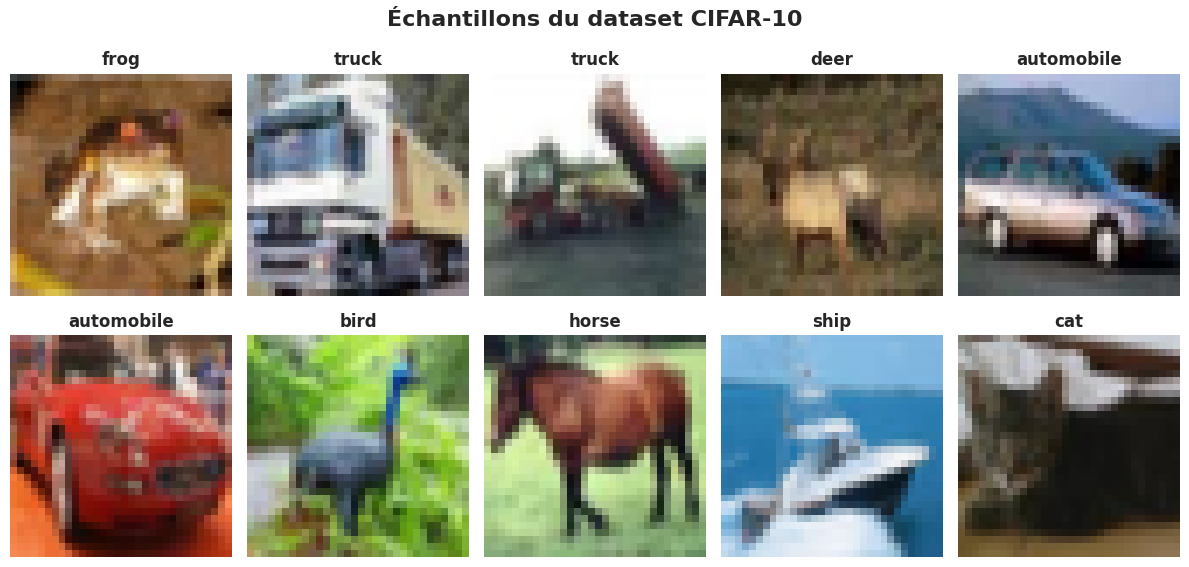

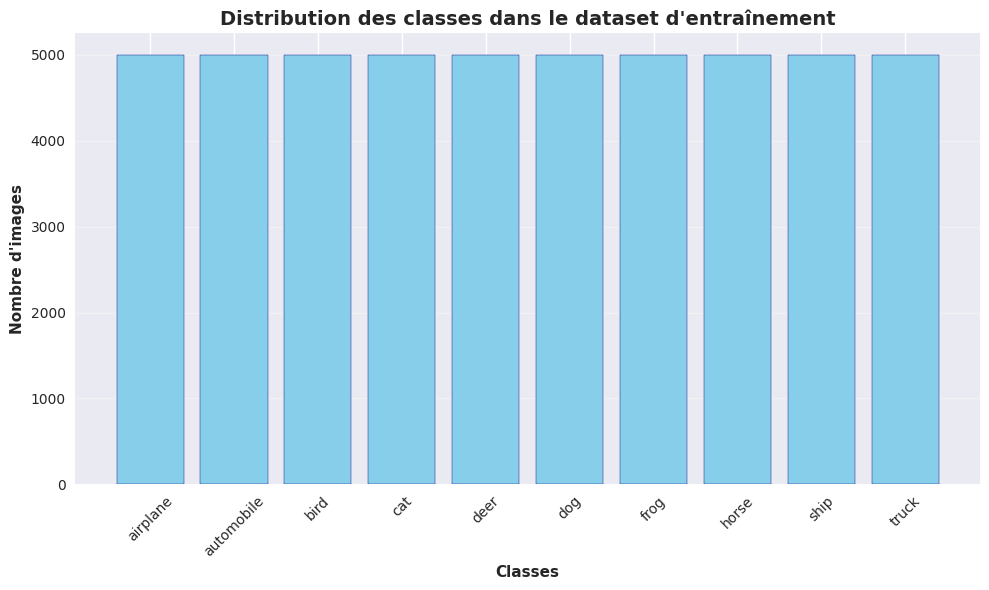

In [5]:
# Visualisation d'échantillons du dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Échantillons du dataset CIFAR-10', fontsize=16, fontweight='bold')

for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(x_train[i])
    ax.set_title(f'{class_names[y_train[i][0]]}', fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Distribution des classes
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='navy')
plt.title('Distribution des classes dans le dataset d\'entraînement', fontsize=14, fontweight='bold')
plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Nombre d\'images', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Préprocessing des images

Le préprocessing est crucial pour améliorer les performances du modèle. Nous normaliserons les données et préparerons l'augmentation de données.

In [6]:
# Normalisation des données (pixels entre 0 et 1)
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Conversion des labels en format catégoriel (one-hot encoding)
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Forme après normalisation:")
print(f"x_train_norm: {x_train_norm.shape}, plage: [{x_train_norm.min():.3f}, {x_train_norm.max():.3f}]")
print(f"y_train_cat: {y_train_cat.shape}")
print(f"Exemple de label one-hot: {y_train_cat[0]}")

# Division des données d'entraînement en train/validation
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_norm, y_train_cat, test_size=0.2, random_state=42, stratify=y_train

)

print(f"\nAprès division train/validation:")
print(f"Entraînement: {x_train_split.shape[0]} images")
print(f"Validation: {x_val_split.shape[0]} images")
print(f"Test: {x_test_norm.shape[0]} images")

Forme après normalisation:
x_train_norm: (50000, 32, 32, 3), plage: [0.000, 1.000]
y_train_cat: (50000, 10)
Exemple de label one-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


: 

In [ ]:
# Configuration de l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotation jusqu'à 20 degrés
    width_shift_range=0.1,      # Décalage horizontal de 10%
    height_shift_range=0.1,     # Décalage vertical de 10%
    horizontal_flip=True,       # Retournement horizontal
    zoom_range=0.1,             # Zoom de ±10%
    fill_mode='nearest'         # Mode de remplissage
)

# Fit du générateur sur les données d'entraînement
datagen.fit(x_train_split)

# Visualisation de l'augmentation de données
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Exemples d\'augmentation de données', fontsize=16, fontweight='bold')

# Image originale
sample_image = x_train_split[0:1]  # Première image
sample_label = class_names[np.argmax(y_train_split[0])]

# Génération d'images augmentées
i = 0
for batch in datagen.flow(sample_image, batch_size=1):
    ax = axes[i//5, i%5]
    ax.imshow(batch[0])
    ax.set_title(f'Augmentation {i+1}' if i > 0 else 'Original', fontweight='bold')
    ax.axis('off')
    i += 1
    if i >= 10:
        break

plt.tight_layout()
plt.show()

## 4. Architecture du CNN

Nous construisons un CNN avec plusieurs couches de convolution, pooling et des couches entièrement connectées.

In [5]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Crée un modèle CNN pour la classification d'images
    
    Args:
        input_shape: Forme des images d'entrée
        num_classes: Nombre de classes à prédire
    
    Returns:
        model: Modèle CNN compilé
    """
    
    model = models.Sequential([
        # Premier bloc convolutionnel
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.Conv2D(32, (3, 3), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25, name='dropout1'),
        
        # Deuxième bloc convolutionnel
        layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),
        layers.BatchNormalization(name='bn2'),
        layers.Conv2D(64, (3, 3), activation='relu', name='conv4'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25, name='dropout2'),
        
        # Troisième bloc convolutionnel
        layers.Conv2D(128, (3, 3), activation='relu', name='conv5'),
        layers.BatchNormalization(name='bn3'),
        layers.Dropout(0.25, name='dropout3'),
        
        # Aplatissement et couches denses
        layers.Flatten(name='flatten'),
        layers.Dense(512, activation='relu', name='dense1'),
        layers.BatchNormalization(name='bn4'),
        layers.Dropout(0.5, name='dropout4'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Création du modèle
model = create_cnn_model()

# Affichage de l'architecture
print("Architecture du CNN:")
model.summary()

# Calcul du nombre total de paramètres
total_params = model.count_params()
print(f"\nNombre total de paramètres: {total_params:,}")

NameError: name 'models' is not defined

In [4]:
# Visualisation de l'architecture du modèle
import tensorflow as tf
tf.keras.utils.plot_model(
    model, 
    to_file='model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    dpi=150
)

from IPython.display import Image, display
display(Image('model_architecture.png'))

2025-08-23 20:54:19.073431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-23 20:54:19.206222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 20:54:33.762598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-23 20:54:46.340043: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

NameError: name 'model' is not defined

## 5. Compilation du modèle

Nous configurons l'optimiseur, la fonction de perte et les métriques d'évaluation.

In [9]:
# Configuration de l'optimiseur
optimizer = optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Pour classification multi-classe
    metrics=['accuracy', 'top_k_categorical_accuracy']  # Métriques d'évaluation
)

print("Modèle compilé avec succès!")
print(f"Optimiseur: {model.optimizer.__class__.__name__}")
print(f"Fonction de perte: {model.loss}")
print(f"Métriques: {model.metrics_names}")

Modèle compilé avec succès!
Optimiseur: Adam
Fonction de perte: categorical_crossentropy
Métriques: ['loss', 'compile_metrics']


In [10]:
# Configuration des callbacks pour l'entraînement
callbacks = [
    # Arrêt précoce si pas d'amélioration
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Sauvegarde du meilleur modèle
    ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    
    # Réduction du learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurés:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")

Callbacks configurés:
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau


## 6. Entraînement du modèle

Nous entraînons le modèle CNN sur nos données avec augmentation de données.

In [11]:
# Configuration de l'entraînement
EPOCHS = 50
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(x_train_split) // BATCH_SIZE

print(f"Configuration d'entraînement:")
print(f"- Époques: {EPOCHS}")
print(f"- Taille de batch: {BATCH_SIZE}")
print(f"- Étapes par époque: {STEPS_PER_EPOCH}")
print(f"- Images d'entraînement: {len(x_train_split)}")
print(f"- Images de validation: {len(x_val_split)}")

# Entraînement du modèle
print("\nDébut de l'entraînement...")
history = model.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=(x_val_split, y_val_split),
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé!")

Configuration d'entraînement:
- Époques: 50
- Taille de batch: 32
- Étapes par époque: 1250
- Images d'entraînement: 40000
- Images de validation: 10000

Début de l'entraînement...
Epoch 1/50


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2849 - loss: 2.3171 - top_k_categorical_accuracy: 0.7948
Epoch 1: val_accuracy improved from None to 0.45400, saving model to best_cnn_model.h5

Epoch 1: val_accuracy improved from None to 0.45400, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 70ms/step - accuracy: 0.3531 - loss: 1.9332 - top_k_categorical_accuracy: 0.8560 - val_accuracy: 0.4540 - val_loss: 1.5255 - val_top_k_categorical_accuracy: 0.9242 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4569 - loss: 1.5039 - top_k_categorical_accuracy: 0.9171
Epoch 2: val_accuracy improved from 0.45400 to 0.52000, saving model to best_cnn_model.h5

Epoch 2: val_accuracy improved from 0.45400 to 0.52000, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.4794 - loss: 1.4425 - top_k_categorical_accuracy: 0.9247 - val_accuracy: 0.5200 - val_loss: 1.4798 - val_top_k_categorical_accuracy: 0.9249 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5239 - loss: 1.3333 - top_k_categorical_accuracy: 0.9374
Epoch 3: val_accuracy improved from 0.52000 to 0.57530, saving model to best_cnn_model.h5

Epoch 3: val_accuracy improved from 0.52000 to 0.57530, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 66ms/step - accuracy: 0.5355 - loss: 1.2988 - top_k_categorical_accuracy: 0.9410 - val_accuracy: 0.5753 - val_loss: 1.2449 - val_top_k_categorical_accuracy: 0.9324 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5644 - loss: 1.2344 - top_k_categorical_accuracy: 0.9465
Epoch 4: val_accuracy improved from 0.57530 to 0.65100, saving model to best_cnn_model.h5

Epoch 4: val_accuracy improved from 0.57530 to 0.65100, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.5781 - loss: 1.1969 - top_k_categorical_accuracy: 0.9504 - val_accuracy: 0.6510 - val_loss: 0.9818 - val_top_k_categorical_accuracy: 0.9641 - learning_rate: 0.0010
Epoch 5/50
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5980 - loss: 1.1352 - top_k_categorical_accuracy: 0.9542
Epoch 5: val_accuracy did not improve from 0.65100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6031 - loss: 1.1186 - top_k_categorical_accuracy: 0.9555 - val_accuracy: 0.6130 - val_loss: 1.1169 - val_top_k_categorical_accuracy: 0.9564 - learning_rate: 0.0010
Epoch 6/50

Epoch 5: val_accuracy did not improve from 0.65100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6031 - loss: 1.1186 - top_k_categorical_accuracy: 0.9555 - val_accuracy: 0.6130 - val_loss: 1.1169 - val_top_k_categorical_accuracy: 0.9564 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6196 - loss

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.6264 - loss: 1.0628 - top_k_categorical_accuracy: 0.9619 - val_accuracy: 0.6597 - val_loss: 0.9832 - val_top_k_categorical_accuracy: 0.9641 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6351 - loss: 1.0379 - top_k_categorical_accuracy: 0.9639
Epoch 7: val_accuracy improved from 0.65970 to 0.66350, saving model to best_cnn_model.h5

Epoch 7: val_accuracy improved from 0.65970 to 0.66350, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.6433 - loss: 1.0192 - top_k_categorical_accuracy: 0.9641 - val_accuracy: 0.6635 - val_loss: 1.0040 - val_top_k_categorical_accuracy: 0.9664 - learning_rate: 0.0010
Epoch 8/50
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6575 - loss: 0.9857 - top_k_categorical_accuracy: 0.9679
Epoch 8: val_accuracy did not improve from 0.66350
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.6588 - loss: 0.9801 - top_k_categorical_accuracy: 0.9676 - val_accuracy: 0.6627 - val_loss: 0.9831 - val_top_k_categorical_accuracy: 0.9648 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.66350
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.6588 - loss: 0.9801 - top_k_categorical_accuracy: 0.9676 - val_accuracy: 0.6627 - val_loss: 0.9831 - val_top_k_categorical_accuracy: 0.9648 - learning_rate: 0.0010
Epoch 9/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6682 - loss

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6697 - loss: 0.9450 - top_k_categorical_accuracy: 0.9693 - val_accuracy: 0.7210 - val_loss: 0.8101 - val_top_k_categorical_accuracy: 0.9732 - learning_rate: 0.0010
Epoch 10/50
Epoch 10/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6718 - loss: 0.9402 - top_k_categorical_accuracy: 0.9700
Epoch 10: val_accuracy did not improve from 0.72100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 66ms/step - accuracy: 0.6743 - loss: 0.9296 - top_k_categorical_accuracy: 0.9706 - val_accuracy: 0.7108 - val_loss: 0.8394 - val_top_k_categorical_accuracy: 0.9701 - learning_rate: 0.0010
Epoch 11/50

Epoch 10: val_accuracy did not improve from 0.72100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 66ms/step - accuracy: 0.6743 - loss: 0.9296 - top_k_categorical_accuracy: 0.9706 - val_accuracy: 0.7108 - val_loss: 0.8394 - val_top_k_categorical_accuracy: 0.9701 - learning_rate: 0.0010
Epoch 11/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.681

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 65ms/step - accuracy: 0.6851 - loss: 0.9049 - top_k_categorical_accuracy: 0.9730 - val_accuracy: 0.7397 - val_loss: 0.7717 - val_top_k_categorical_accuracy: 0.9736 - learning_rate: 0.0010
Epoch 12/50
   7/1250 ━━━━━━━━━━━━━━━━━━━━ 1:44 84ms/step - accuracy: 0.7641 - loss: 0.7814 - top_k_categorical_accuracy: 0.9623Epoch 12/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6899 - loss: 0.8961 - top_k_categorical_accuracy: 0.9722
Epoch 12: val_accuracy did not improve from 0.73970
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.6906 - loss: 0.8874 - top_k_categorical_accuracy: 0.9732 - val_accuracy: 0.7232 - val_loss: 0.8347 - val_top_k_categorical_accuracy: 0.9697 - learning_rate: 0.0010
Epoch 13/50

Epoch 12: val_accuracy did not improve from 0.73970
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.6906 - loss: 0.8874 - top_k_categorical_accuracy: 0.9732 - val_accuracy: 0.7232 - val_loss: 0.8347 - val_top_k_categorical

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.6980 - loss: 0.8730 - top_k_categorical_accuracy: 0.9742 - val_accuracy: 0.7532 - val_loss: 0.7223 - val_top_k_categorical_accuracy: 0.9777 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7022 - loss: 0.8551 - top_k_categorical_accuracy: 0.9754
Epoch 14: val_accuracy did not improve from 0.75320
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7030 - loss: 0.8533 - top_k_categorical_accuracy: 0.9765 - val_accuracy: 0.7313 - val_loss: 0.7747 - val_top_k_categorical_accuracy: 0.9785 - learning_rate: 0.0010
Epoch 15/50

Epoch 14: val_accuracy did not improve from 0.75320
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7030 - loss: 0.8533 - top_k_categorical_accuracy: 0.9765 - val_accuracy: 0.7313 - val_loss: 0.7747 - val_top_k_categorical_accuracy: 0.9785 - learning_rate: 0.0010
Epoch 15/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7143 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7238 - loss: 0.8022 - top_k_categorical_accuracy: 0.9784 - val_accuracy: 0.7843 - val_loss: 0.6256 - val_top_k_categorical_accuracy: 0.9848 - learning_rate: 0.0010
Epoch 19/50
Epoch 19/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7254 - loss: 0.7934 - top_k_categorical_accuracy: 0.9786
Epoch 19: val_accuracy did not improve from 0.78430
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.7232 - loss: 0.8031 - top_k_categorical_accuracy: 0.9776 - val_accuracy: 0.7357 - val_loss: 0.7796 - val_top_k_categorical_accuracy: 0.9801 - learning_rate: 0.0010
Epoch 20/50

Epoch 19: val_accuracy did not improve from 0.78430
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.7232 - loss: 0.8031 - top_k_categorical_accuracy: 0.9776 - val_accuracy: 0.7357 - val_loss: 0.7796 - val_top_k_categorical_accuracy: 0.9801 - learning_rate: 0.0010
Epoch 20/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7224 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.7261 - loss: 0.7916 - top_k_categorical_accuracy: 0.9793 - val_accuracy: 0.7848 - val_loss: 0.6292 - val_top_k_categorical_accuracy: 0.9833 - learning_rate: 0.0010
Epoch 21/50
Epoch 21/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7351 - loss: 0.7684 - top_k_categorical_accuracy: 0.9800
Epoch 21: val_accuracy did not improve from 0.78480
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7315 - loss: 0.7763 - top_k_categorical_accuracy: 0.9800 - val_accuracy: 0.7686 - val_loss: 0.6977 - val_top_k_categorical_accuracy: 0.9768 - learning_rate: 0.0010
Epoch 22/50

Epoch 21: val_accuracy did not improve from 0.78480
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7315 - loss: 0.7763 - top_k_categorical_accuracy: 0.9800 - val_accuracy: 0.7686 - val_loss: 0.6977 - val_top_k_categorical_accuracy: 0.9768 - learning_rate: 0.0010
Epoch 22/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7325 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.7394 - loss: 0.7486 - top_k_categorical_accuracy: 0.9805 - val_accuracy: 0.7902 - val_loss: 0.6140 - val_top_k_categorical_accuracy: 0.9838 - learning_rate: 0.0010
Epoch 26/50
Epoch 26/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7411 - loss: 0.7436 - top_k_categorical_accuracy: 0.9821
Epoch 26: val_accuracy did not improve from 0.79020
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.7421 - loss: 0.7449 - top_k_categorical_accuracy: 0.9809 - val_accuracy: 0.7654 - val_loss: 0.7150 - val_top_k_categorical_accuracy: 0.9769 - learning_rate: 0.0010
Epoch 27/50

Epoch 26: val_accuracy did not improve from 0.79020
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.7421 - loss: 0.7449 - top_k_categorical_accuracy: 0.9809 - val_accuracy: 0.7654 - val_loss: 0.7150 - val_top_k_categorical_accuracy: 0.9769 - learning_rate: 0.0010
Epoch 27/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7479 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.7485 - loss: 0.7288 - top_k_categorical_accuracy: 0.9832 - val_accuracy: 0.7919 - val_loss: 0.6045 - val_top_k_categorical_accuracy: 0.9875 - learning_rate: 0.0010
Epoch 31/50
Epoch 31/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7533 - loss: 0.7120 - top_k_categorical_accuracy: 0.9827
Epoch 31: val_accuracy did not improve from 0.79190
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7526 - loss: 0.7160 - top_k_categorical_accuracy: 0.9829 - val_accuracy: 0.7613 - val_loss: 0.7190 - val_top_k_categorical_accuracy: 0.9833 - learning_rate: 0.0010
Epoch 32/50

Epoch 31: val_accuracy did not improve from 0.79190
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7526 - loss: 0.7160 - top_k_categorical_accuracy: 0.9829 - val_accuracy: 0.7613 - val_loss: 0.7190 - val_top_k_categorical_accuracy: 0.9833 - learning_rate: 0.0010
Epoch 32/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7544 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.7559 - loss: 0.7088 - top_k_categorical_accuracy: 0.9823 - val_accuracy: 0.7981 - val_loss: 0.5862 - val_top_k_categorical_accuracy: 0.9874 - learning_rate: 0.0010
Epoch 34/50
Epoch 34/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7573 - loss: 0.7053 - top_k_categorical_accuracy: 0.9835
Epoch 34: val_accuracy did not improve from 0.79810
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.7566 - loss: 0.7060 - top_k_categorical_accuracy: 0.9830 - val_accuracy: 0.7641 - val_loss: 0.7086 - val_top_k_categorical_accuracy: 0.9805 - learning_rate: 0.0010
Epoch 35/50

Epoch 34: val_accuracy did not improve from 0.79810
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.7566 - loss: 0.7060 - top_k_categorical_accuracy: 0.9830 - val_accuracy: 0.7641 - val_loss: 0.7086 - val_top_k_categorical_accuracy: 0.9805 - learning_rate: 0.0010
Epoch 35/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7553 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7585 - loss: 0.6999 - top_k_categorical_accuracy: 0.9832 - val_accuracy: 0.8010 - val_loss: 0.5881 - val_top_k_categorical_accuracy: 0.9863 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7626 - loss: 0.6950 - top_k_categorical_accuracy: 0.9833
Epoch 37: val_accuracy did not improve from 0.80100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.7617 - loss: 0.6919 - top_k_categorical_accuracy: 0.9831 - val_accuracy: 0.7794 - val_loss: 0.6538 - val_top_k_categorical_accuracy: 0.9859 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.80100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.7617 - loss: 0.6919 - top_k_categorical_accuracy: 0.9831 - val_accuracy: 0.7794 - val_loss: 0.6538 - val_top_k_categorical_accuracy: 0.9859 - learning_rate: 0.0010
Epoch 38/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7612 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.7614 - loss: 0.6950 - top_k_categorical_accuracy: 0.9836 - val_accuracy: 0.8177 - val_loss: 0.5325 - val_top_k_categorical_accuracy: 0.9888 - learning_rate: 0.0010
Epoch 39/50
Epoch 39/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7678 - loss: 0.6795 - top_k_categorical_accuracy: 0.9856
Epoch 39: val_accuracy did not improve from 0.81770
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.7642 - loss: 0.6858 - top_k_categorical_accuracy: 0.9852 - val_accuracy: 0.8025 - val_loss: 0.5875 - val_top_k_categorical_accuracy: 0.9884 - learning_rate: 0.0010
Epoch 40/50

Epoch 39: val_accuracy did not improve from 0.81770
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.7642 - loss: 0.6858 - top_k_categorical_accuracy: 0.9852 - val_accuracy: 0.8025 - val_loss: 0.5875 - val_top_k_categorical_accuracy: 0.9884 - learning_rate: 0.0010
Epoch 40/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7644 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.7776 - loss: 0.6422 - top_k_categorical_accuracy: 0.9869 - val_accuracy: 0.8254 - val_loss: 0.5174 - val_top_k_categorical_accuracy: 0.9896 - learning_rate: 2.0000e-04
Epoch 45/50
Epoch 45/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7825 - loss: 0.6290 - top_k_categorical_accuracy: 0.9866
Epoch 45: val_accuracy did not improve from 0.82540
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - accuracy: 0.7851 - loss: 0.6238 - top_k_categorical_accuracy: 0.9868 - val_accuracy: 0.8214 - val_loss: 0.5262 - val_top_k_categorical_accuracy: 0.9890 - learning_rate: 2.0000e-04
Epoch 46/50

Epoch 45: val_accuracy did not improve from 0.82540
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - accuracy: 0.7851 - loss: 0.6238 - top_k_categorical_accuracy: 0.9868 - val_accuracy: 0.8214 - val_loss: 0.5262 - val_top_k_categorical_accuracy: 0.9890 - learning_rate: 2.0000e-04
Epoch 46/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accur

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.7872 - loss: 0.6191 - top_k_categorical_accuracy: 0.9868 - val_accuracy: 0.8298 - val_loss: 0.4990 - val_top_k_categorical_accuracy: 0.9901 - learning_rate: 2.0000e-04
Epoch 48/50
Epoch 48/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7925 - loss: 0.6038 - top_k_categorical_accuracy: 0.9876
Epoch 48: val_accuracy improved from 0.82980 to 0.83140, saving model to best_cnn_model.h5

Epoch 48: val_accuracy improved from 0.82980 to 0.83140, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 67ms/step - accuracy: 0.7904 - loss: 0.6056 - top_k_categorical_accuracy: 0.9871 - val_accuracy: 0.8314 - val_loss: 0.5012 - val_top_k_categorical_accuracy: 0.9893 - learning_rate: 2.0000e-04
Epoch 49/50
Epoch 49/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7884 - loss: 0.6065 - top_k_categorical_accuracy: 0.9887
Epoch 49: val_accuracy improved from 0.83140 to 0.83730, saving model to best_cnn_model.h5

Epoch 49: val_accuracy improved from 0.83140 to 0.83730, saving model to best_cnn_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.7919 - loss: 0.6020 - top_k_categorical_accuracy: 0.9882 - val_accuracy: 0.8373 - val_loss: 0.4798 - val_top_k_categorical_accuracy: 0.9910 - learning_rate: 2.0000e-04
Epoch 50/50
Epoch 50/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7926 - loss: 0.6084 - top_k_categorical_accuracy: 0.9880
Epoch 50: val_accuracy did not improve from 0.83730
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 0.7901 - loss: 0.6124 - top_k_categorical_accuracy: 0.9872 - val_accuracy: 0.8350 - val_loss: 0.4846 - val_top_k_categorical_accuracy: 0.9900 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 49.

Epoch 50: val_accuracy did not improve from 0.83730
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 0.7901 - loss: 0.6124 - top_k_categorical_accuracy: 0.9872 - val_accuracy: 0.8350 - val_loss: 0.4846 - val_top_k_categorical_accuracy: 0.9900 - learning_rate: 2.0000e-04
Restoring mod

## 7. Évaluation et visualisation des résultats

Analysons les performances du modèle et visualisons les résultats de l'entraînement.

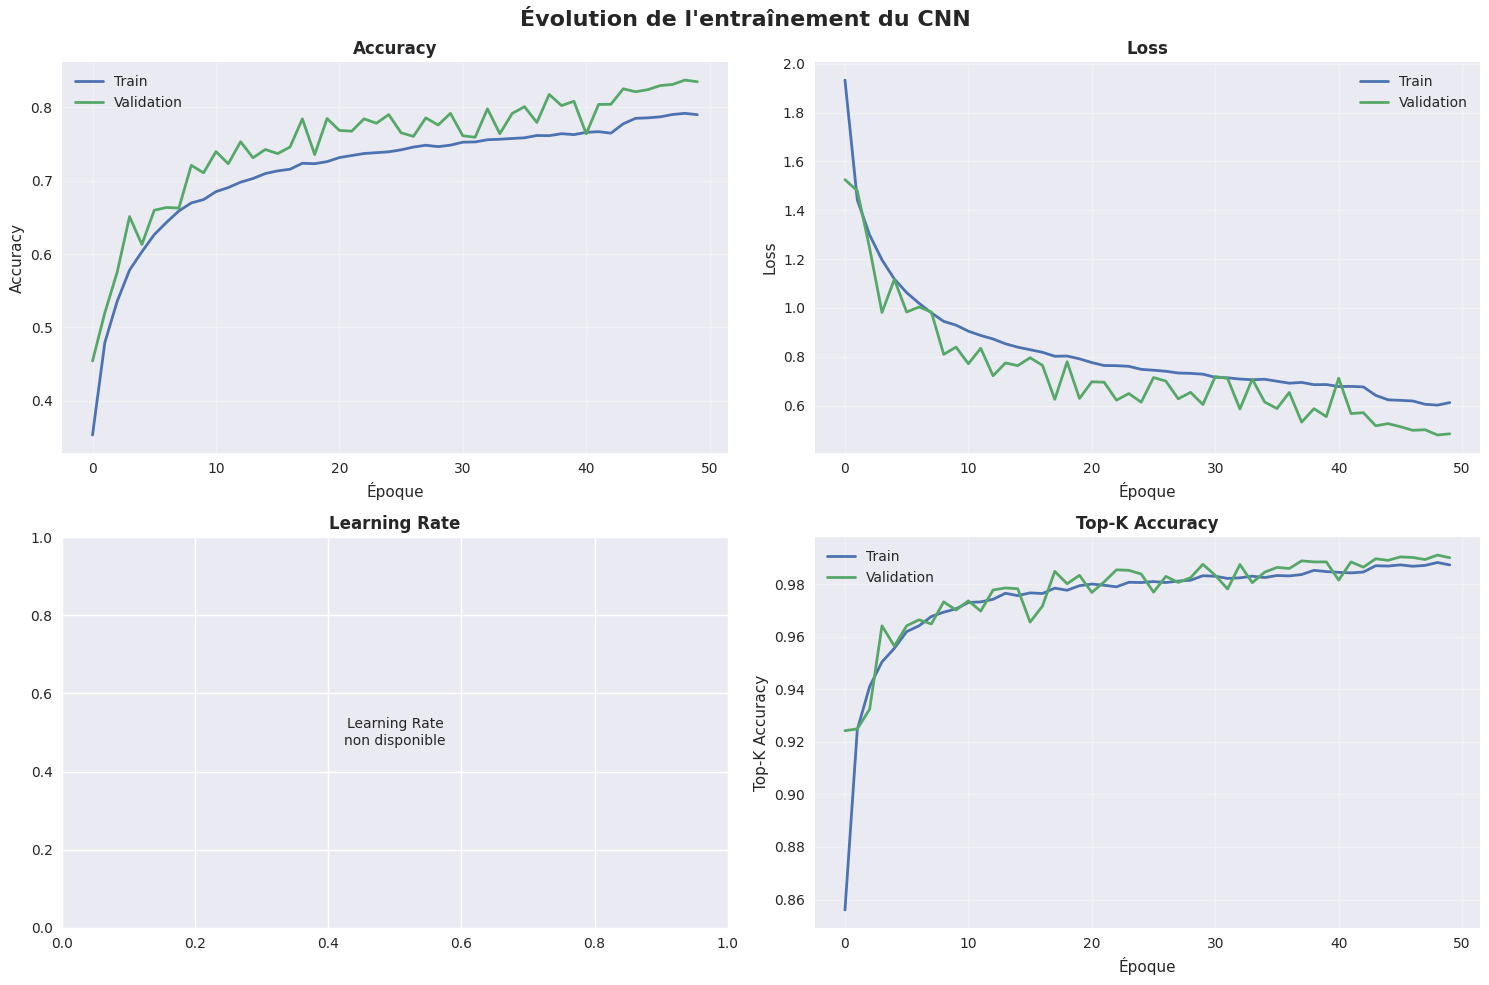

Métriques finales d'entraînement:
- Accuracy finale (train): 0.7901
- Accuracy finale (validation): 0.8350
- Loss finale (train): 0.6124
- Loss finale (validation): 0.4846


In [12]:
# Visualisation des courbes d'entraînement
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Évolution de l\'entraînement du CNN', fontsize=16, fontweight='bold')

# Accuracy
axes[0,0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0,0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0,0].set_title('Accuracy', fontweight='bold')
axes[0,0].set_xlabel('Époque')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Loss
axes[0,1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0,1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0,1].set_title('Loss', fontweight='bold')
axes[0,1].set_xlabel('Époque')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Learning Rate (si disponible)
if 'lr' in history.history:
    axes[1,0].plot(history.history['lr'], linewidth=2, color='red')
    axes[1,0].set_title('Learning Rate', fontweight='bold')
    axes[1,0].set_xlabel('Époque')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].set_yscale('log')
    axes[1,0].grid(True, alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'Learning Rate\nnon disponible', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Learning Rate', fontweight='bold')

# Top-k accuracy
if 'top_k_categorical_accuracy' in history.history:
    axes[1,1].plot(history.history['top_k_categorical_accuracy'], label='Train', linewidth=2)
    axes[1,1].plot(history.history['val_top_k_categorical_accuracy'], label='Validation', linewidth=2)
    axes[1,1].set_title('Top-K Accuracy', fontweight='bold')
    axes[1,1].set_xlabel('Époque')
    axes[1,1].set_ylabel('Top-K Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Affichage des métriques finales
print("Métriques finales d'entraînement:")
print(f"- Accuracy finale (train): {history.history['accuracy'][-1]:.4f}")
print(f"- Accuracy finale (validation): {history.history['val_accuracy'][-1]:.4f}")
print(f"- Loss finale (train): {history.history['loss'][-1]:.4f}")
print(f"- Loss finale (validation): {history.history['val_loss'][-1]:.4f}")

Évaluation sur les données de test:

Résultats sur le jeu de test:
- Test Loss: 0.4875
- Test Accuracy: 0.8318 (83.18%)
- Test Top-K Accuracy: 0.9924 (99.24%)


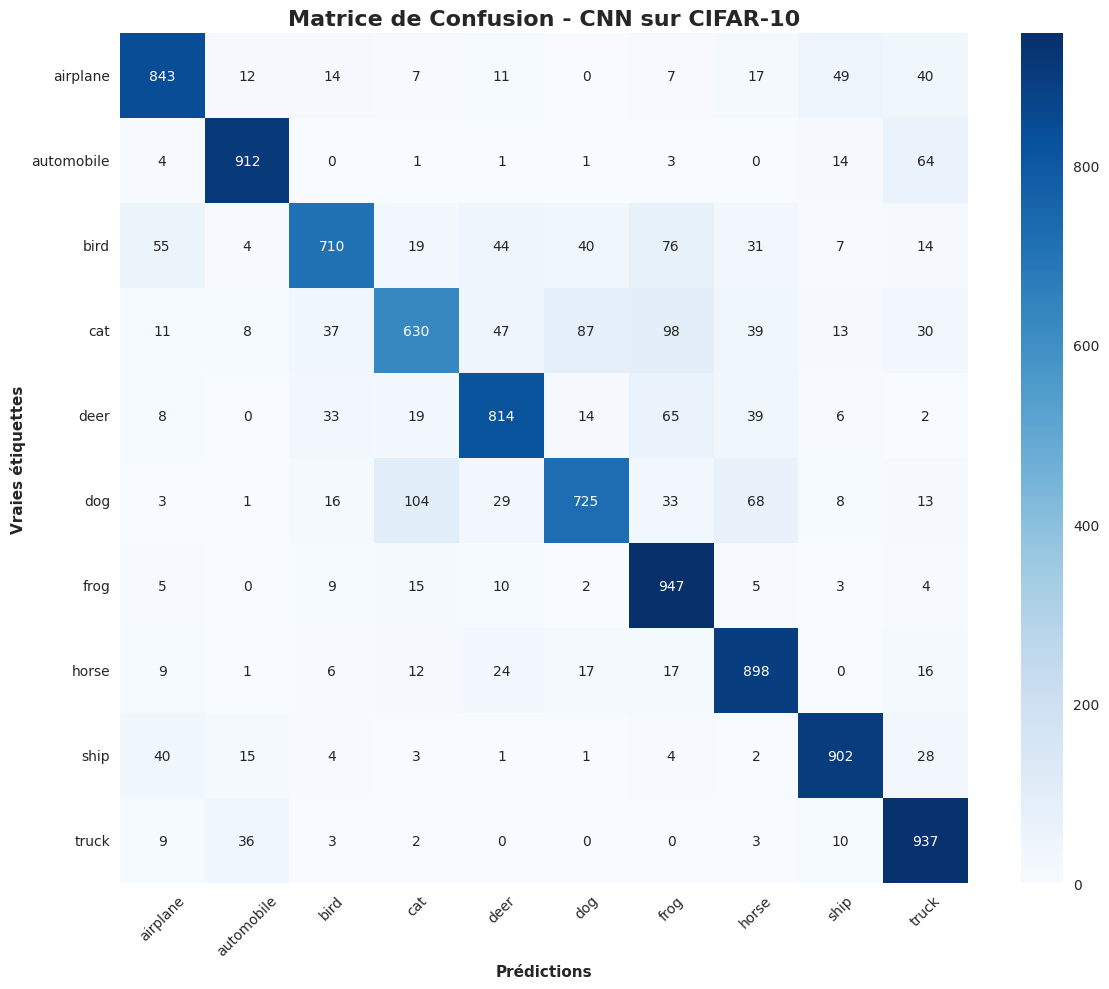


Rapport de classification détaillé:
              precision    recall  f1-score   support

    airplane       0.85      0.84      0.85      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.85      0.71      0.78      1000
         cat       0.78      0.63      0.70      1000
        deer       0.83      0.81      0.82      1000
         dog       0.82      0.72      0.77      1000
        frog       0.76      0.95      0.84      1000
       horse       0.81      0.90      0.85      1000
        ship       0.89      0.90      0.90      1000
       truck       0.82      0.94      0.87      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [13]:
# Évaluation sur les données de test
print("Évaluation sur les données de test:")
test_loss, test_accuracy, test_top_k = model.evaluate(
    x_test_norm, y_test_cat, verbose=0
)

print(f"\nRésultats sur le jeu de test:")
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"- Test Top-K Accuracy: {test_top_k:.4f} ({test_top_k*100:.2f}%)")

# Prédictions sur le jeu de test
y_pred_prob = model.predict(x_test_norm, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - CNN sur CIFAR-10', fontsize=16, fontweight='bold')
plt.xlabel('Prédictions', fontweight='bold')
plt.ylabel('Vraies étiquettes', fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_true, y_pred, target_names=class_names))

Nombre de prédictions correctes: 8318 (83.18%)
Nombre de prédictions incorrectes: 1682 (16.82%)


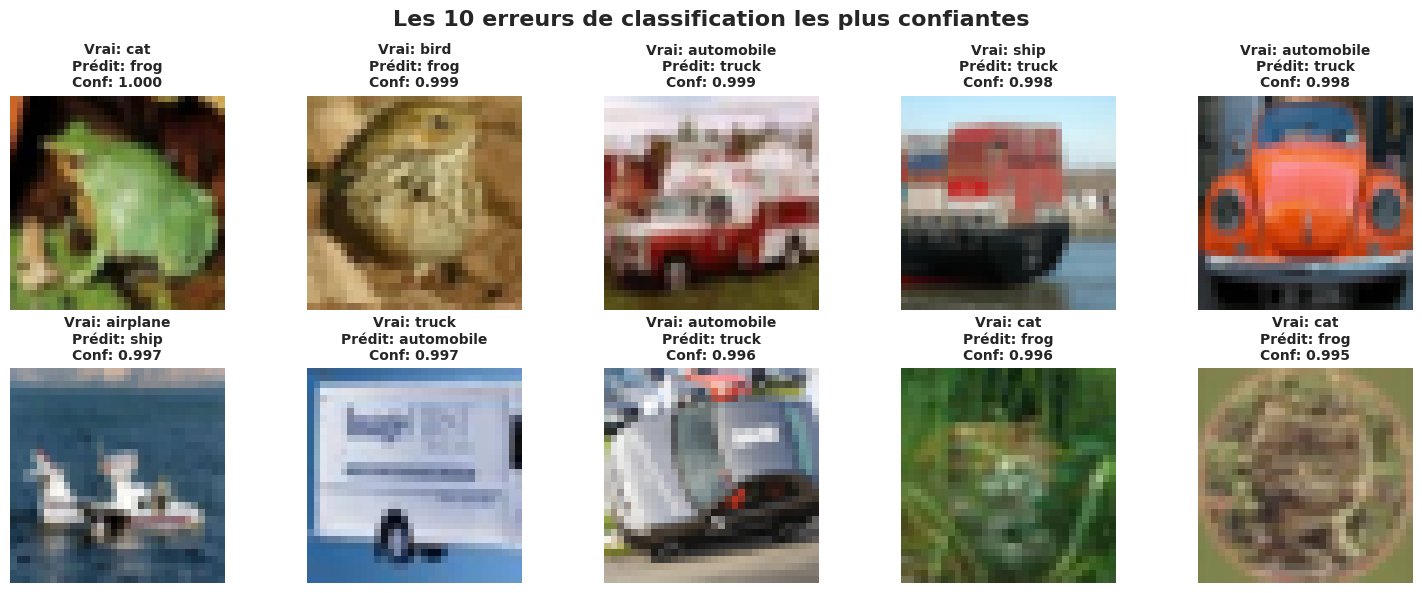

In [14]:
# Analyse des erreurs de classification
# Trouver les indices des prédictions incorrectes
incorrect_indices = np.where(y_pred != y_true)[0]
correct_indices = np.where(y_pred == y_true)[0]

print(f"Nombre de prédictions correctes: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.2f}%)")
print(f"Nombre de prédictions incorrectes: {len(incorrect_indices)} ({len(incorrect_indices)/len(y_true)*100:.2f}%)")

# Visualisation des erreurs les plus confiantes
if len(incorrect_indices) > 0:
    # Calculer la confiance des prédictions incorrectes
    incorrect_confidences = np.max(y_pred_prob[incorrect_indices], axis=1)
    
    # Trier par confiance décroissante
    sorted_indices = incorrect_indices[np.argsort(incorrect_confidences)[::-1]]
    
    # Afficher les 10 erreurs les plus confiantes
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Les 10 erreurs de classification les plus confiantes', fontsize=16, fontweight='bold')
    
    for i in range(min(10, len(sorted_indices))):
        idx = sorted_indices[i]
        ax = axes[i//5, i%5]
        
        ax.imshow(x_test[idx])
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred[idx]]
        confidence = np.max(y_pred_prob[idx])
        
        ax.set_title(f'Vrai: {true_class}\nPrédit: {pred_class}\nConf: {confidence:.3f}', 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. Prédictions sur de nouvelles images

Testons notre modèle sur quelques images et analysons ses prédictions.

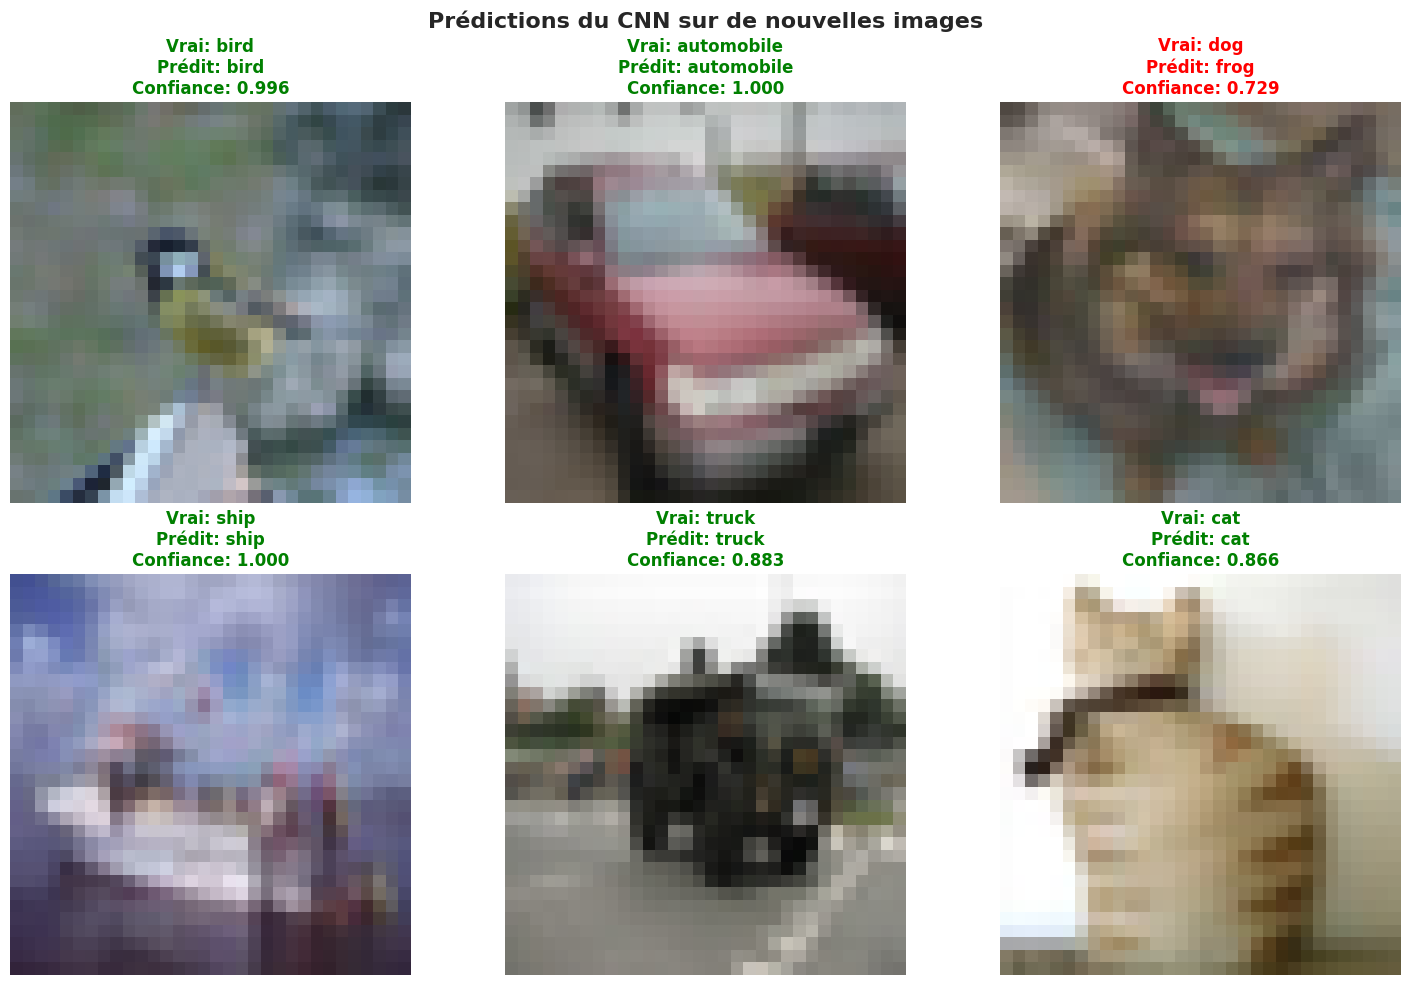

In [15]:
def predict_image(model, image, class_names, top_k=3):
    """
    Prédit la classe d'une image et affiche les top-k prédictions
    
    Args:
        model: Modèle entraîné
        image: Image à classer (normalisée)
        class_names: Noms des classes
        top_k: Nombre de prédictions à afficher
    
    Returns:
        predictions: Probabilités pour chaque classe
    """
    # Prédiction
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    predictions = model.predict(image, verbose=0)[0]
    
    # Top-k prédictions
    top_indices = np.argsort(predictions)[::-1][:top_k]
    
    print(f"Top-{top_k} prédictions:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[idx]*100:.2f}%")
    
    return predictions

# Test sur quelques images du jeu de test
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Prédictions du CNN sur de nouvelles images', fontsize=16, fontweight='bold')

# Sélection d'images aléatoirement
np.random.seed(42)
test_indices = np.random.choice(len(x_test_norm), 6, replace=False)

for i, idx in enumerate(test_indices):
    ax = axes[i//3, i%3]
    
    # Affichage de l'image
    ax.imshow(x_test[idx])
    
    # Prédiction
    image = x_test_norm[idx]
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    
    predicted_class = np.argmax(predictions)
    true_class = y_test[idx][0]
    confidence = np.max(predictions)
    
    # Titre avec résultat
    color = 'green' if predicted_class == true_class else 'red'
    ax.set_title(f'Vrai: {class_names[true_class]}\n'
                f'Prédit: {class_names[predicted_class]}\n'
                f'Confiance: {confidence:.3f}', 
                color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

Analyse détaillée de l'image 1741
Vraie classe: deer
Top-5 prédictions:
1. dog: 52.01%
2. cat: 26.42%
3. deer: 16.82%
4. bird: 2.07%
5. horse: 1.68%


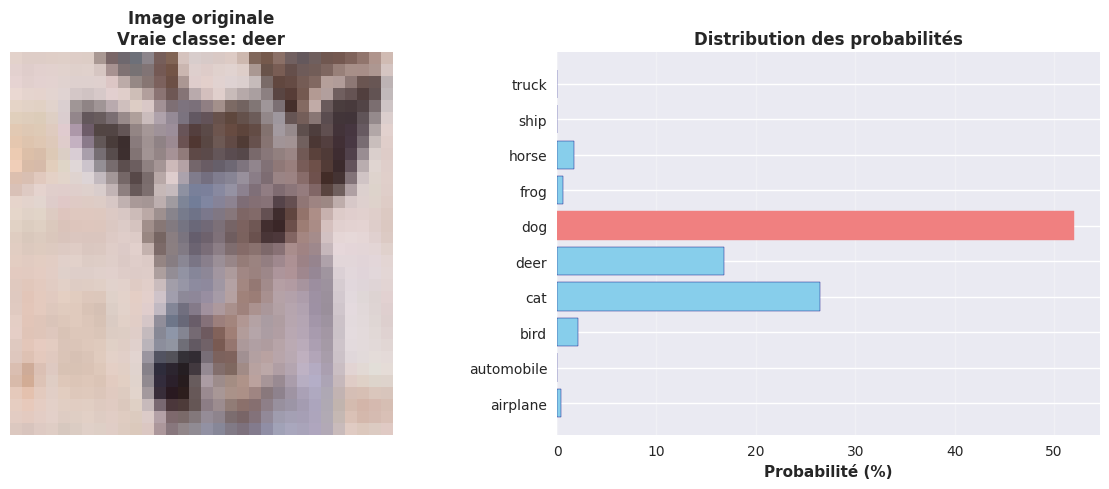

In [16]:
# Analyse détaillée d'une prédiction
sample_idx = np.random.choice(len(x_test_norm))
sample_image = x_test_norm[sample_idx]
true_label = class_names[y_test[sample_idx][0]]

print(f"Analyse détaillée de l'image {sample_idx}")
print(f"Vraie classe: {true_label}")
print("="*50)

# Prédiction détaillée
predictions = predict_image(model, sample_image, class_names, top_k=5)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Image originale
ax1.imshow(x_test[sample_idx])
ax1.set_title(f'Image originale\nVraie classe: {true_label}', fontweight='bold')
ax1.axis('off')

# Graphique des probabilités
y_pos = np.arange(len(class_names))
bars = ax2.barh(y_pos, predictions*100, color='skyblue', edgecolor='navy')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(class_names)
ax2.set_xlabel('Probabilité (%)', fontweight='bold')
ax2.set_title('Distribution des probabilités', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Highlighting de la prédiction maximale
max_idx = np.argmax(predictions)
bars[max_idx].set_color('lightcoral')

plt.tight_layout()
plt.show()

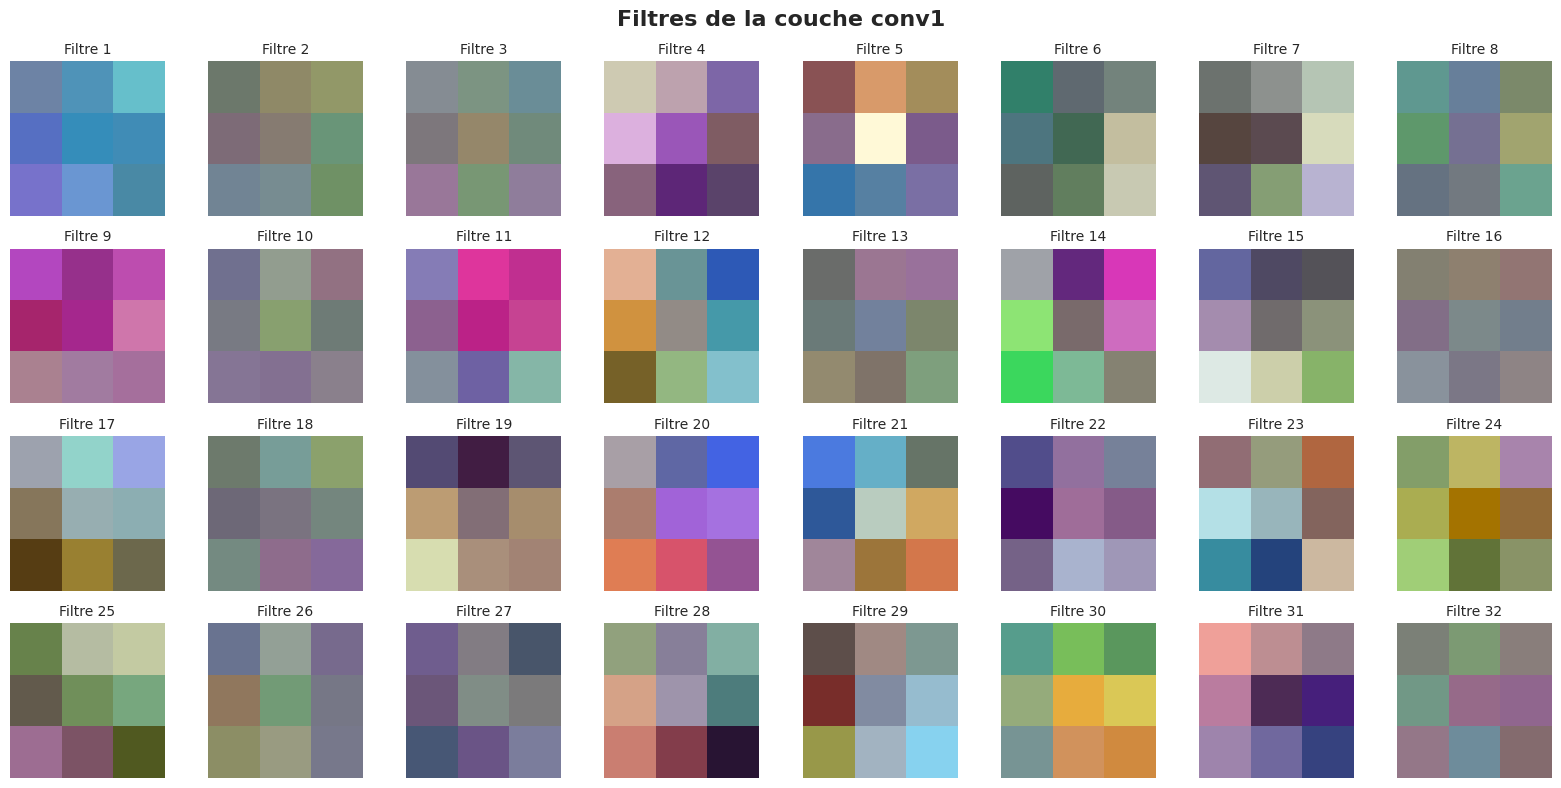

In [17]:
# Visualisation des filtres de la première couche convolutionnelle
def visualize_filters(model, layer_name, num_filters=32):
    """
    Visualise les filtres d'une couche convolutionnelle
    """
    # Récupération des poids de la couche
    layer = model.get_layer(layer_name)
    filters = layer.get_weights()[0]
    
    # Normalisation des filtres pour l'affichage
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # Affichage
    num_filters = min(num_filters, filters.shape[-1])
    cols = 8
    rows = (num_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows*2))
    fig.suptitle(f'Filtres de la couche {layer_name}', fontsize=16, fontweight='bold')
    
    for i in range(num_filters):
        ax = axes[i//cols, i%cols] if rows > 1 else axes[i%cols]
        
        # Affichage du filtre (moyenne sur les canaux de couleur)
        filter_img = filters[:, :, :, i]
        if filter_img.shape[-1] == 3:  # RGB
            ax.imshow(filter_img)
        else:  # Grayscale
            ax.imshow(filter_img[:, :, 0], cmap='viridis')
        
        ax.set_title(f'Filtre {i+1}', fontsize=10)
        ax.axis('off')
    
    # Masquer les axes non utilisés
    for i in range(num_filters, rows*cols):
        ax = axes[i//cols, i%cols] if rows > 1 else axes[i%cols]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisation des filtres de la première couche
visualize_filters(model, 'conv1', num_filters=32)

In [18]:
# Sauvegarde du modèle final
model.save('cnn_cifar10_final.h5')
print("Modèle sauvegardé sous 'cnn_cifar10_final.h5'")

# Sauvegarde de l'historique d'entraînement
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Historique d'entraînement sauvegardé sous 'training_history.pkl'")

# Résumé final des performances
print("\n" + "="*60)
print("RÉSUMÉ FINAL DU MODÈLE CNN")
print("="*60)
print(f"Dataset: CIFAR-10 ({len(class_names)} classes)")
print(f"Architecture: CNN avec {total_params:,} paramètres")
print(f"Accuracy sur validation: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"Accuracy sur test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Nombre d'époques entraînées: {len(history.history['accuracy'])}")
print("="*60)

Modèle sauvegardé sous 'cnn_cifar10_final.h5'
Historique d'entraînement sauvegardé sous 'training_history.pkl'

RÉSUMÉ FINAL DU MODÈLE CNN
Dataset: CIFAR-10 (10 classes)
Architecture: CNN avec 737,834 paramètres
Accuracy sur validation: 0.8373 (83.73%)
Accuracy sur test: 0.8318 (83.18%)
Nombre d'époques entraînées: 50


## Conclusion

Ce TP nous a permis de :

1. **Implémenter un CNN complet** avec des couches de convolution, pooling, et dense
2. **Entraîner le modèle** sur le dataset CIFAR-10 avec augmentation de données
3. **Évaluer les performances** avec différentes métriques
4. **Visualiser les résultats** et analyser les erreurs
5. **Faire des prédictions** sur de nouvelles images

### Points clés appris :
- L'importance du préprocessing et de l'augmentation de données
- L'architecture CNN avec BatchNormalization et Dropout pour éviter l'overfitting
- L'utilisation de callbacks pour optimiser l'entraînement
- L'analyse des résultats avec des métriques appropriées

### Améliorations possibles :
- Utiliser des architectures plus avancées (ResNet, DenseNet)
- Implémenter du transfer learning
- Optimiser les hyperparamètres
- Tester sur d'autres datasets